# Exploring restaurants in San Francisco

## Table of Contents

* [Introduction](#introduction)
* [Data Collection and Cleaning](#data-collection)
* [Objective](#objective)
* [Data Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

<a id="introduction"></a>
## Introduction 

San Francisco bay area has a large number of restaurants and food places. This study is trying to analyze various restaurant place, coffee shops and in general food places in SF Bay Area. 

<a id="data-collection"></a>

## Data Collection and Cleaning

We are using Foursquare API to get list of venue in SF. Foursquare provides search/explore APIs to find all different places related to Food Category.

We are using Yelp API to find yelp ratings, price category, no of ratings etc. Foursquare API also offers similar data but it is only available through Premium account. Thats why we are relying on the Yelp.

Data collected through Foresquare and Yelp does not match. There are 3 types of problems

* Venues collected from Foresquare do not exist in Yelp. We ignored such venues for this study.
* Venues collected from Foresquare have slightly different name or location details than Yelp. We ignored such venues because they were very few.
* Some important data like Rating, Price Category was missing in Yelp. We ignore such venues because they were less 5. 


### Data configuration

*Foresquare API Parameters*

In [1]:
VERSION = '20190528'
# removed just before commiting code\n",
CLIENT_ID = '0HH2B0MRFB2FALD3CL3SQAGF5KPCVO53DS5OEOKOP4MWUCJO' 
CLIENT_SECRET = 'D5KMPZK1RAFC0RSUS3VCUOIAIIA2KVCOWHIP1RJX3D1L0UQS'

FOOD_CATEGORY = '4d4b7105d754a06374d81259'


*Yelp API Parameters*

In [2]:
# removed just before commiting code\n",
YELP_CLIENT_ID = 'Bq6qmlBBIrfG1nKIIJXCpQ'
YELP_CLIENT_SECRET = 'Ljx0_IiTbEpvRU5ZjBubu7wSy0W8_31kyL9saDkS3U-8mxIxnztOaKrQiM_aBoj1Fb0za5S4QkU0Zu_emrd71M9z6Rqi_okGeOW3Inrk87SlDdhDYxtEuo0V_I2SXnYx'

*Other Configuration Parameters*

In [3]:
LIMIT = 100
RADIUS = 6000
NO_OF_CLUSTERS = 5

SF_LAT = 37.7749 
SF_LONG= -122.4194

Lets import all the required libraries. These libraries include pandas, numpy for all dataset related operations. *pandas.io.json* helps normalize and convert json data into dataframe. *folium* helps visualize maps. 

In [4]:
import numpy as np
import pandas as pd
import json 
from geopy.geocoders import Nominatim
import requests
from pandas.io.json import json_normalize

import matplotlib.cm as cm
import matplotlib.colors as colors

from sklearn.cluster import KMeans

import folium
#!pip install yelpapi
from yelpapi import YelpAPI

%matplotlib inline 

import matplotlib as mpl
import matplotlib.pyplot as plt




Lets define some commonly used functions. 

In [5]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

San Francisco is tech capitol of silicon valley. It has large number of technology companies from big coporations to small startups. We are plugging in coordinates of SF directly as other sources sometimes unreliable. SF coordinats are **37.7749** and **-122.4194**. We will explore restaurants and food places in san francisco so let map the area with above coordinates.

In [6]:
map_sf = folium.Map(location=[SF_LAT, SF_LONG], zoom_start=12)
folium.Circle(
    radius=RADIUS,
    location=[SF_LAT, SF_LONG],
    popup='San Franciso',
    color='crimson',
    fill=False,
).add_to(map_sf)


### Foresquare API 
Foresquare provides basic throught their free developer account provides basic APIs like searching venue, exploring surrounding of spacific location or neighborhood. Through their premium API we can get more details like tips, ratings for given venue. Foresquare API is accessible [here](https://developer.foursquare.com/docs/build-with-foursquare/)


Below we are using venue search API. We are passing special *Food Category* and *intent=browse* to this API along with client auth parameters and search specific parameters. API returns json data with many data points and attributes. Rename some columns and filter out important columns. 

In [7]:
f_restaurants = pd.DataFrame(columns = ['Name', 'Categories', 'Latitude', 'Longitude', 'Address'])
limit = 500
count = 0
while (count < limit):
    url = 'https://api.foursquare.com/v2/venues/search?\
                        &client_id={}&client_secret={}&v={}&ll={},{}\
                        &radius={}&limit={}&intent=browse&categoryId={}'.format(
                                                                        CLIENT_ID, 
                                                                        CLIENT_SECRET, 
                                                                        VERSION, 
                                                                        SF_LAT, 
                                                                        SF_LONG, 
                                                                        RADIUS, 
                                                                        LIMIT,
                                                                        FOOD_CATEGORY
                                                                        )
    
    result = requests.get(url).json()
    venues_fetched = len(result['response']['venues'])
    venues = result['response']['venues']
    venues = json_normalize(venues)

    filtered_columns = ['name', 'categories', 'location.lat', 'location.lng', 'location.address']
    venues = venues.loc[:, filtered_columns]
    venues['categories'] = venues.apply(get_category_type, axis = 1)
    # Rename columns
    venues.rename(columns={'name':'Name', 'categories':'Categories',\
                          'location.lat':'Latitude', 'location.lng':'Longitude',\
                          'location.address':'Address'}, inplace=True)
    f_restaurants = pd.concat([f_restaurants, venues], axis = 0, sort = False)
    if (venues_fetched < 50):
        break
    else:
        count = count + 50

f_restaurants.reset_index(inplace=True, drop=True)

print("\nTotal {} food places queried".format(count))

/Users/anup/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead



Total 500 food places queried


In [18]:
map_sf = folium.Map(location=[SF_LAT, SF_LONG], zoom_start=13)
map_sf

# add markers to map
for lat, lng, label in zip(f_restaurants['Latitude'], \
                                   f_restaurants['Longitude'], f_restaurants['Name']):
    label = folium.Popup(label, parse_html=True)
    folium.Circle(
    radius=RADIUS,
    location=[SF_LAT, SF_LONG],
    popup='San Franciso',
    color='crimson',
    fill=False,
    ).add_to(map_sf)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_sf)
map_sf.save("sf_orig_foursqaure.html")
map_sf

In [8]:
f_restaurants['Categories'].value_counts()

Coffee Shop                  80
Bakery                       50
Grocery Store                40
Café                         30
Supermarket                  20
Bubble Tea Shop              20
Salad Place                  20
Donut Shop                   20
Food & Drink Shop            10
Mexican Restaurant           10
Sandwich Place               10
Food Court                   10
Ice Cream Shop               10
Ramen Restaurant             10
Japanese Curry Restaurant    10
New American Restaurant      10
Filipino Restaurant          10
Beer Bar                     10
American Restaurant          10
Japanese Restaurant          10
Chocolate Shop               10
Pizza Place                  10
Cantonese Restaurant         10
Brazilian Restaurant         10
Restaurant                   10
Market                       10
Burger Joint                 10
Dumpling Restaurant          10
Italian Restaurant           10
Video Store                  10
Name: Categories, dtype: int64

### Yelp API

Yelp is online service to search and rate various types of restaurants and food places. Since Foursquare API to retrieve ratings and other characteristics of restaurants, we are using Yelp API to query these details.

Similar to Foresquare, Yelp has extensive REST API to query businesses and events. Lets query Yelp Business for each of restaurant we queried using Foresquare API.  

But unlike Foresquare, we have Yelp SDK called *YelpAPI* available to query data.

In [9]:
yelp_api = YelpAPI(YELP_CLIENT_SECRET)

In [ ]:
# Define function to query data using Yelp SDK. 
def getYelpRankings(names, latitudes, longitudes, addresses, radius=500):
    
    shops=[]
    for name, lat, lng, address in zip(names, latitudes, longitudes, addresses):
        #print(name)
        try:
            yelp_result = yelp_api.business_match_query(name=name, address1=address,\
                                                city='San Francisco', state='CA', country='US')
            if yelp_result['businesses']:
                business_id = yelp_result['businesses'][0]['id']
                business_detail = yelp_api.business_query(id=business_id)
                business = json_normalize(business_detail) # flatten JSON
                interested_columns=['name', 'categories', 'location.display_address', 'coordinates.latitude', 'coordinates.longitude', \
                        'price', 'rating', 'review_count']
                if set(interested_columns).issubset(business.columns) == True:
                    business = business.loc[:, interested_columns]
                    for row in business.itertuples():
                        shops.append([(
                            name, 
                            lat, 
                            lng, 
                            row[6], 
                            row[7], 
                            row[8]
                            )])
#            else:
#                print("### No yelp data found for business {} at address {} ".format(name, address))
        except:
            a = 1+1
#            print("### No yelp business {} found in yelp database {} ".format(name, address))
    
    yelp_restuarants = pd.DataFrame([item for shops in shops for item in shops])
    yelp_restuarants.columns = ['Name', 
                  'Latitude', 
                  'Longitude', 
                  'Price', 
                  'Rating', 
                  'Review Count']
    
    return(yelp_restuarants)


Below code calles function getYelpRankings by passing names, lattitude, longitude and addresses queried from Foresqaure. This function takes care of ignoring business which does not exist in Yelp database.

In [ ]:
y_restaurants = getYelpRankings(names=f_restaurants['Name'],
                                   latitudes=f_restaurants['Latitude'],
                                   longitudes=f_restaurants['Longitude'],
                                   addresses=f_restaurants['Address']
                                  )
y_restaurants.head()

In [21]:
map_sf = folium.Map(location=[SF_LAT, SF_LONG], zoom_start=13)
map_sf

# add markers to map
for lat, lng, label in zip(f_restaurants['Latitude'], \
                                   f_restaurants['Longitude'], f_restaurants['Name']):
    label = folium.Popup(label, parse_html=True)
    folium.Circle(
    radius=RADIUS,
    location=[SF_LAT, SF_LONG],
    popup='San Franciso',
    color='crimson',
    fill=False,
    ).add_to(map_sf)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_sf)
map_sf.save("sf_orig_yelp.html")
map_sf

Lets map these places on SF Map. Lets highlight places with rating > 4.0 with blue.

In [14]:
map_sf = folium.Map(location=[SF_LAT, SF_LONG], zoom_start=13)
map_sf

# add markers to map
for lat, lng, label, rating in zip(y_restaurants['Latitude'], \
                                   y_restaurants['Longitude'], y_restaurants['Name'], \
                                  y_restaurants['Rating']):
    label = folium.Popup(label, parse_html=True)
    folium.Circle(
    radius=RADIUS,
    location=[SF_LAT, SF_LONG],
    popup='San Franciso',
    color='crimson',
    fill=False,
    ).add_to(map_sf)
    if( rating > 4.0 ):
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color='blue',
            fill=True,
            fill_color='#3186cc',
            fill_opacity=0.7,
            parse_html=False).add_to(map_sf)
    else:
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color='red',
            fill=True,
            fill_color='#3186cc',
            fill_opacity=0.7,
            parse_html=False).add_to(map_sf)

map_sf.save("sf_orig.html")
map_sf

Lets merge data from Foursquare and Yelp into new dataset called restaurants

In [154]:
restaurants=pd.concat([y_restaurants,f_restaurants['Categories']], axis=1, join='inner')

## drop data with Category as 'Video Store'
restaurants=restaurants[restaurants.Categories != 'Video Store']

## Merge data of two rows by their category. E.g. Merge Cafe and Coffee Shop together
restaurants.replace('Market', 'Supermarket', inplace=True)
restaurants.replace('Grocery Store', 'Supermarket', inplace=True)

restaurants.replace('Japanese Curry Restaurant', 'Japanese Restaurant', inplace=True)

restaurants.replace('New American Restaurant', 'American Restaurant', inplace=True)

restaurants.replace('Food & Drink Shop', 'Food Court', inplace=True)

restaurants.replace('Café', 'Coffee Shop', inplace=True)


In [155]:
# Convert Price $, $$ and $$$ to 1,2,3 means low, medium and high
restaurants.replace('$$$', 3, inplace=True)
restaurants.replace('$$', 2, inplace=True)
restaurants.replace('$', 1, inplace=True)

restaurants.astype({'Price': 'int'}).dtypes



Name             object
Latitude        float64
Longitude       float64
Price             int64
Rating          float64
Review Count      int64
Categories       object
dtype: object

<a id="objective"></a>

## Objective

The objective of study is to give a comprehensive overview of location, rating, price range and other characteristics of the restaurants. Primary objective is to be able to tell if someone can open a restaurant in a specific neighborhood and what kind of restaurant that might be.

<a id='analysis'></a>
## Data Analysis

Lets analyse above collected data. 

As one can see there are various types of restaurants from multiple cuisine and ethanicity. Lets see how these categories stacks up with each other.

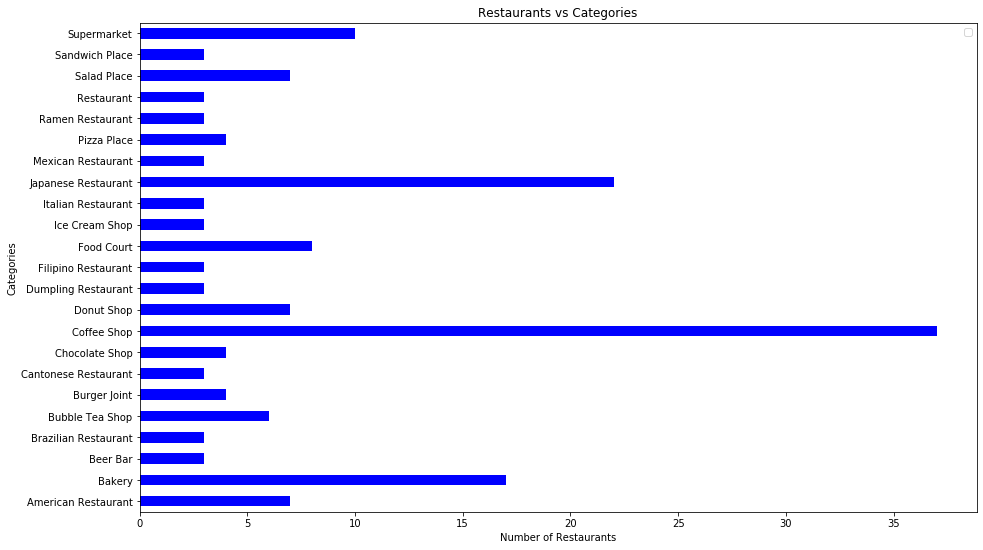

In [156]:
rest_categories =pd.DataFrame(restaurants.groupby('Categories')['Name'].count())
# <-- Quick gradient example along the Red/Green dimensions.
my_colors = list(islice(cycle(['b', 'r', 'g', 'y', 'k']), None, len(restaurants)))

rest_categories.plot(kind='barh', figsize=(15, 9), color=my_colors)


plt.ylabel('Categories')
plt.xlabel('Number of Restaurants')
plt.title('Restaurants vs Categories')
plt.legend('')

plt.show()


Lets see how the rating looks like for these restaurants

Text(0.5, 1.0, 'Count of Restaurant with given rating')

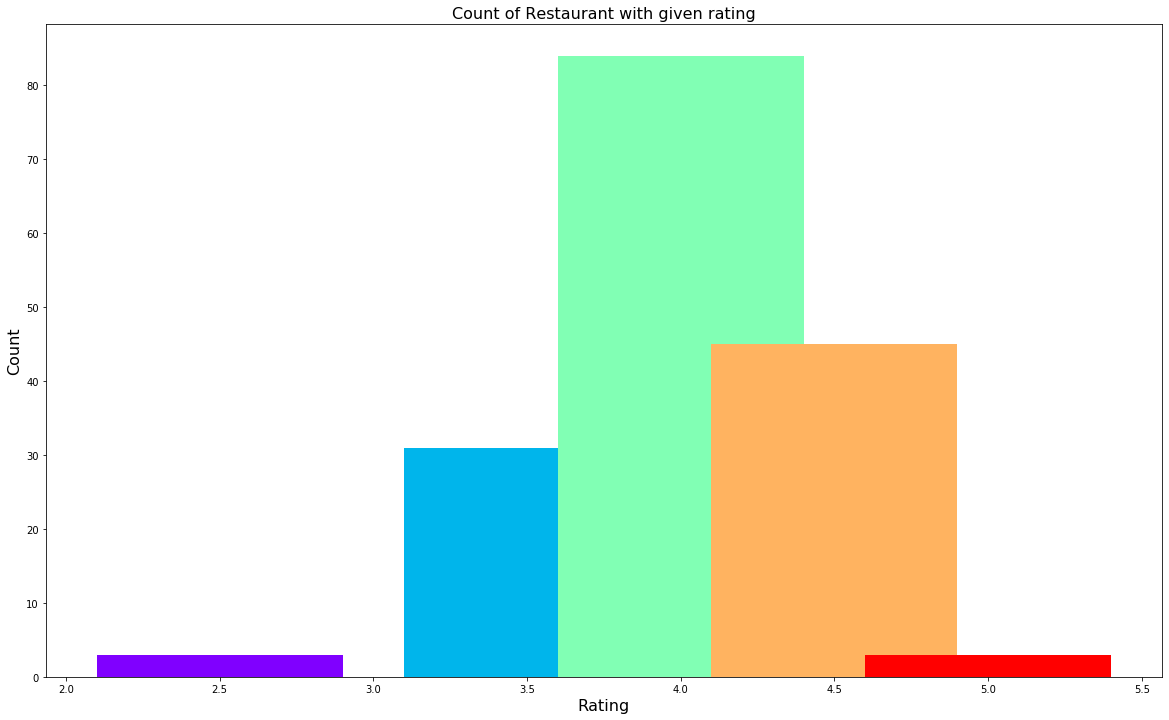

In [157]:
restaurants['Rating'] = restaurants['Rating'].astype(float)
rating = restaurants['Rating'].value_counts().sort_index()
plt.figure(figsize = (20, 12))
plt.bar(rating.index, rating.values, color = cm.rainbow(np.linspace(0, 1, len(rating.index))))
plt.xlabel("Rating", fontsize = 16)
plt.ylabel("Count", fontsize = 16)
plt.title("Count of Restaurant with given rating", fontsize = 16)

In [158]:
bins = [1.0, 2.0, 3.0, 4.0]
labels = ['Low', 'Medium', 'High']
restaurants['Price_Bin'] = pd.cut(restaurants['Price'].astype(float), bins = bins, \
                                  labels = labels, include_lowest = True)

bins = [1.0, 2.0, 3.0, 4.0, 5.0]
labels = ['Ok', 'Good', 'Great', 'Excellent']
restaurants['Rating_Bin'] = pd.cut(restaurants['Rating'].astype(float), bins = bins, \
                                  labels = labels, include_lowest = True)

restaurants.head()

,Name,Latitude,Longitude,Price,Rating,Review Count,Categories,Price_Bin,Rating_Bin
0,Costco Food Court,37.770760,-122.410616,1,3.5,142,Food Court,Low,Great
1,Shake Shack,37.797899,-122.435469,2,2.5,170,Burger Joint,Low,Good
2,Gus’s Community Market,37.763974,-122.412841,2,4.0,230,Japanese Restaurant,Low,Great
3,Nopa,37.774888,-122.437532,3,4.0,5067,American Restaurant,Medium,Great
4,The Market,37.776560,-122.417275,2,3.5,430,Food Court,Low,Great


Clustering

In [159]:
cluster_res = restaurants
from sklearn.cluster import KMeans

NO_OF_CLUSTERS = 2

clustering = cluster_res.drop(['Name', 'Review Count', 'Rating_Bin', 'Price_Bin', 'Categories'], 1)
kMeans = KMeans(n_clusters = NO_OF_CLUSTERS, random_state = 0).fit(clustering)
cluster_res.insert(0, 'cluster_labels', kMeans.labels_)
cluster_res.head(20)

,cluster_labels,Name,Latitude,Longitude,Price,Rating,Review Count,Categories,Price_Bin,Rating_Bin
0,1,Costco Food Court,37.770760,-122.410616,1,3.5,142,Food Court,Low,Great
1,0,Shake Shack,37.797899,-122.435469,2,2.5,170,Burger Joint,Low,Good
2,0,Gus’s Community Market,37.763974,-122.412841,2,4.0,230,Japanese Restaurant,Low,Great
3,0,Nopa,37.774888,-122.437532,3,4.0,5067,American Restaurant,Medium,Great
4,0,The Market,37.776560,-122.417275,2,3.5,430,Food Court,Low,Great
5,0,Ritual Coffee Roasters,37.776476,-122.424281,2,4.0,329,Coffee Shop,Low,Great
6,0,Ritual Coffee Roasters,37.756435,-122.421231,2,3.5,1905,Salad Place,Low,Great
7,0,Bi-Rite Market,37.761450,-122.424698,3,4.5,931,Coffee Shop,Medium,Excellent
8,0,Square Pie Guys,37.779229,-122.410870,2,4.5,227,Japanese Restaurant,Low,Excellent
9,0,Bi-Rite Market,37.774796,-122.437739,2,4.5,492,Pizza Place,Low,Excellent


In [160]:
sf_map = folium.Map(location = [SF_LAT, SF_LONG], zoom_start = 13)
color_map = { 0: 'green', 1: 'red'}

# add venues to the map
markers_colors = []
for venue,  cluster, latitude, longitude in zip(cluster_res['Name'], 
                                                     
                                                        cluster_res['cluster_labels'], 
                                                        cluster_res['Latitude'], 
                                                        cluster_res['Longitude']):
    label = folium.Popup(str(venue), parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 5,
        popup = label,
        color = color_map[cluster],
        fill = True,
        fill_color = color_map[cluster],
        fill_opacity = 0.7).add_to(sf_map)

# add cluster centers to the map
for index, cluster in enumerate(kMeans.cluster_centers_):
    latitude = cluster[0]
    longitude = cluster[1]
    label = folium.Popup("Cluster: " + str(index), parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 10,
        popup = label,
        color = color_map[index],
        fill = True,
        fill_color = color_map[index],
        fill_opacity = 0.7).add_to(sf_map)

sf_map.save("sf_new.html")
sf_map

#### Cluster 0

In [162]:
result = cluster_res[cluster_res['cluster_labels'] == 0]
print("Cluster 0")
result.head(10).reset_index(drop = True)

Cluster 0


,cluster_labels,Name,Latitude,Longitude,Price,Rating,Review Count,Categories,Price_Bin,Rating_Bin
0,0,Shake Shack,37.797899,-122.435469,2,2.5,170,Burger Joint,Low,Good
1,0,Gus’s Community Market,37.763974,-122.412841,2,4.0,230,Japanese Restaurant,Low,Great
2,0,Nopa,37.774888,-122.437532,3,4.0,5067,American Restaurant,Medium,Great
3,0,The Market,37.776560,-122.417275,2,3.5,430,Food Court,Low,Great
4,0,Ritual Coffee Roasters,37.776476,-122.424281,2,4.0,329,Coffee Shop,Low,Great
5,0,Ritual Coffee Roasters,37.756435,-122.421231,2,3.5,1905,Salad Place,Low,Great
6,0,Bi-Rite Market,37.761450,-122.424698,3,4.5,931,Coffee Shop,Medium,Excellent
7,0,Square Pie Guys,37.779229,-122.410870,2,4.5,227,Japanese Restaurant,Low,Excellent
8,0,Bi-Rite Market,37.774796,-122.437739,2,4.5,492,Pizza Place,Low,Excellent
9,0,Falletti Foods,37.773238,-122.438999,3,3.5,345,Coffee Shop,Medium,Great


Cluster 1

In [163]:
result = cluster_res[cluster_res['cluster_labels'] == 1]
print("Cluster 1")
result.head(10).reset_index(drop = True)

Cluster 1


,cluster_labels,Name,Latitude,Longitude,Price,Rating,Review Count,Categories,Price_Bin,Rating_Bin
0,1,Costco Food Court,37.770760,-122.410616,1,3.5,142,Food Court,Low,Great
1,1,Flywheel Coffee,37.769505,-122.453384,1,4.0,459,Supermarket,Low,Great
2,1,Four Barrel Coffee,37.767008,-122.421902,1,4.0,2089,Chocolate Shop,Low,Great
3,1,Bob's Donuts,37.791797,-122.421085,1,4.5,3019,Bakery,Low,Excellent
4,1,Saint Frank,37.798461,-122.422249,1,4.5,672,American Restaurant,Low,Excellent
5,1,Arizmendi Bakery Panaderia & Pizzeria,37.752498,-122.420812,1,4.5,630,Supermarket,Low,Excellent
6,1,Taqueria El Farolito,37.752654,-122.418313,1,4.0,4909,Coffee Shop,Low,Great
7,1,Duc Loi Supermarket,37.761845,-122.419496,1,4.0,225,Italian Restaurant,Low,Great
8,1,Humphry Slocombe,37.752801,-122.411970,1,4.0,3374,Salad Place,Low,Great
9,1,Bob's On Baker,37.776542,-122.441773,1,4.5,32,Coffee Shop,Low,Excellent


### Observation and Discussion 

This project is attempted to give overview of restaurants in SF area. Data was queried through Foresquare and Yelp to get rating, prices and other characteristics. 

First we queries all the restaurant data. Our dataset had around **4000** restaurants. Then we cleaned our dataset. We dropped places which didn't have Yelp data or missing data.

There were some errors in data like incorrect categorization. We dropped such data from our dataset.

We also merged some common categories which had different categorization so that we compare accurate data.

Then we plotted categories on bar charts to see distribution of restuarants and categories.

One can see that SF bay area has wide variety of restaurants and food place. Given its code weather and tech nature, Coffee Shops are most in area. It was surprising to see so many Japapnese Restaurants.

There is even distribution of Excellent restaurant across SF Bay area. 



## Conclusion

This project has tried to explore various restaurants, categories of San Francisco. Similar analysis can be done for each metropolitan area so that its easy to locate good quality restaurnts. This project has two publicly available data from sources like Foursquare and Yelp. But its possible to get more data sources like Facebook, Google etc. 

